# YOLO 이전 object방식.
- Object proposal과 object classification & bounding box regresiion 단계를 거쳐서 detection이 이루어졌다.


- 즉 이미지 하나로부터 수천개의 proposal을 만들고 각각에 대해 분류기를 돌려 물체를 검출하는 형태이다.
    - 1장 처리에 매우 많은 연산량이 필요.
    - background noise를 물체로 오인식하는 경우가 다수.
    
    
- 각 stage를 이루는 모듈을 각각 개발해야 해서, 전체 pipeline을 아우르는 통합적인 최적화가 불가능.

# YOLO(You Only Look Once
- R-CNN은 복잡한 처리과정으로 인해 Object의 디테일을 한 눈에 파악하기가 어렵다.


- YOLO는 이미지 내의 bounding box 와 class probability를 **single regression problem**으로 간주해, 이미지를 한 번 보는 것으로 object의 종류와 위치를 추측한다.

- 장점
    - 간단한 처리과정으로 속도가 매우 빠르다.
    - image 전체를 한 번에 바라보는 방식으로 class에 대한 맥락적 이해도가 높다.
        - 낮은 background 에러
    - Object에 대해 좀 더 일반화된 특징을 학습.
        - 예를 들어, natural image로 학습을 한 뒤, 이를 artwork에 대해 est하면 상대적으로 높은 성능을 보여준다.
    - single neural network forward 만으로 결과를 얻을 수 있어 매우 빠르다.

- 단점
    - 상대적으로 낮은 정확도. *특히 작은 object에 대해
    

## Unified Detection

### 기본적인 방식.

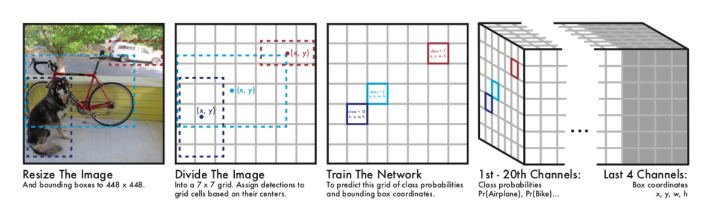

In [13]:
from IPython.display import Image
Image('../image/yolo_9.png')

7x7 Grid: 이미지를 7x7로 나누고, 해당 Object의 중심점이 위치한 grid에서 해당 물체의 bounding box와 class를 출력한다.

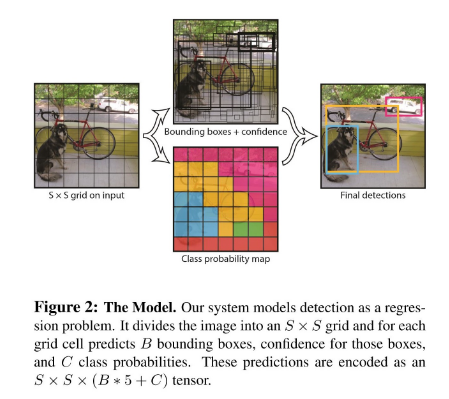

In [3]:
from IPython.display import Image
Image('../image/yolo_1.png')

1. input image를 S X S grid로 나눈다.


2. 각각의 grid cell은 B개의 bounding box와 각 bounding box에 대한 confidence score를 갖는다.
    - 만약 cell에 object가 존재하지 않는다면 confidence score는 0.
    - **Confidence Score** : $Pr(Object)*IOU^{truth}_{pred}$
    
    
3. 각각의 grid cell은 C개의 conditional class probability를 갖는다.
    - Conditional Class Probability:$Pr(Class_i|Object)$
    
    
4. 각각의 bounding box는 x, y, w, h, confidence로 구성된다.\
    - (x, y) : Bounding Box의 중심점. grid cell의 범위에 대한 상대값이 입력된다.
    - (w, h) : 전체 이미지의 width, height에 대한 상대값이 입력된다.
        - 예) 만약 x가 grid cell의 가장 왼쪽에 있다면 x=0, y가 grid cell의 중간에 있다면 y=0.5.
        - 예) bbox의 width가 이미지 width의 절반이라면 w=0.5.
        
5. Test time에는 conditional class probability와 bounding box의 confidence score를 곱하여 class-specific confidence score를 얻는다.


$$ClassSpecificConfidencScore = ConditionalClassProbability * ConfidenceScore$$
$$=Pr(Classi|Object)*Pr(Object)*IOU^truth_pred$$
$$=Pr(Classi)*IOU^truth_pred$$

## Network Design
- GoogLeNet for image classification 모델을 기반으로 함.


- 9개의 convolutional layer와 2개의 fully connected layers

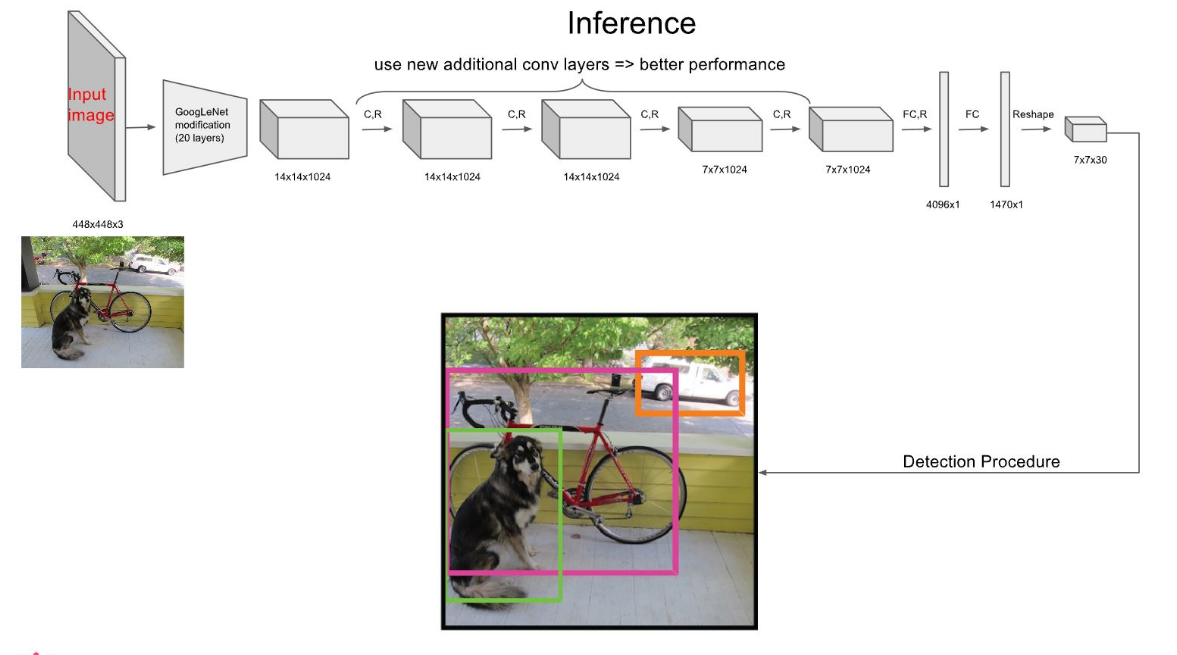

In [1]:
from IPython.display import Image
Image('../image/yolo_2.png')

## Inference Process
- 7x7은 49개의 Grid Cell을 의미한다.

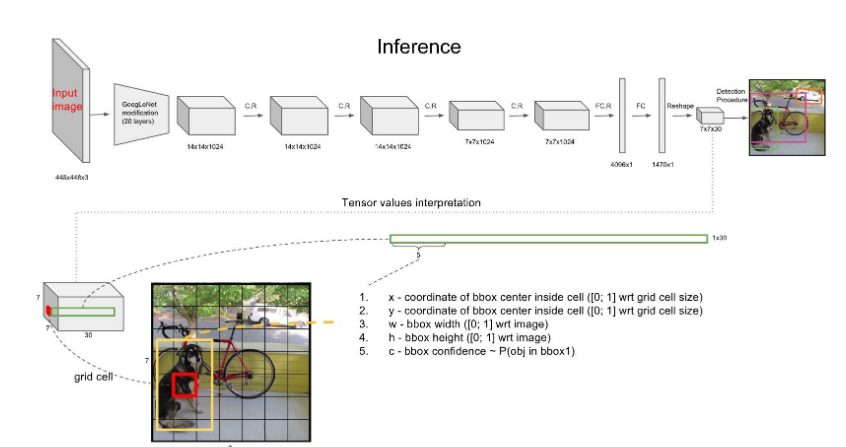

In [1]:
from IPython.display import Image
Image('../image/yolo_3.png')

- 각각의 Grid Cell은 B개의 bounding box를 가지고 있는데(여기선 B=2), 앞 5개의 값은 해당 Grid cell의 첫 번째 bounding box에 대한 값이 채워져있다.

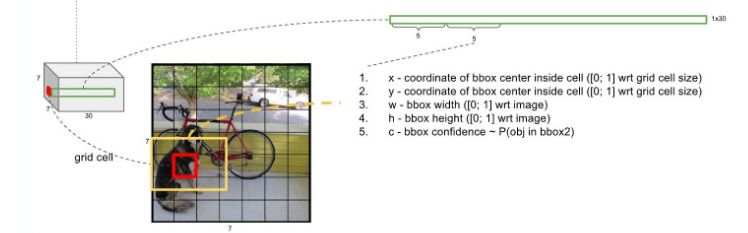

In [2]:
from IPython.display import Image
Image('../image/yolo_4.png')

- 그 다음 5개의 값은 두 번째 bounding box에 대한 내용이다.

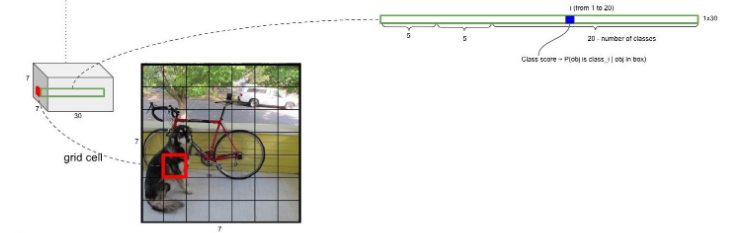

In [3]:
from IPython.display import Image
Image('../image/yolo_5.png')

- 나머지 20개의 값은 20개의 class에 대한 conditional class probability에 해당한다.

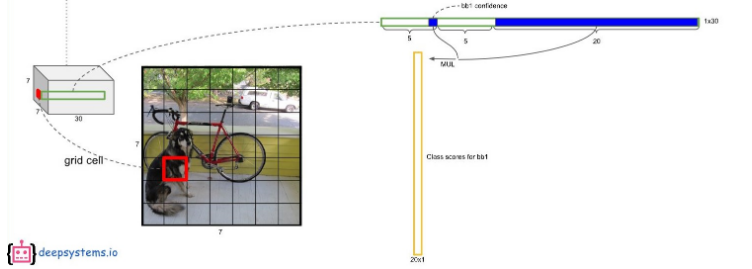

In [4]:
from IPython.display import Image
Image('../image/yolo_6.png')

- 첫번째 bounding box의 confidence score와 각 conditional class probability를 곱하면 첫 번째 bounding box의 class specific confidence score가 나온다.


- 마찬가지로, 두 번째 bounding box의 confidence score와 각 conditional class probability를 곱하면 두번째 bounding box의 class specific confidence score가 나온다.

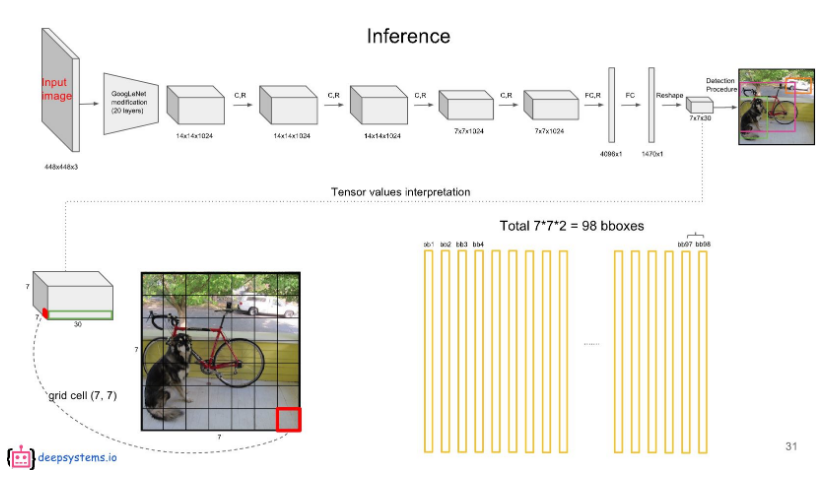

In [5]:
from IPython.display import Image
Image('../image/yolo_7.png')

- 이 계산을 각 bounding box에 대해 하게되면 총 98개의 class specific confidence score를 얻을 수 있다.


- 이 98개의 class specific confidence score에 대해 각 20개의 클래스를 기준으로 non-maximum suppression을 하여, object에 대한 class 및 bounding box location을 결정한다.

## Training Process
- 전제 조건
    1. Grid cell의 여러 bounding box들 중, ground-truth box와의 IOU가 가장 높은 bounding box를 predictor로 설정.
    
    2. 1의 기준에 따라 아래 기호들이 사용된다.

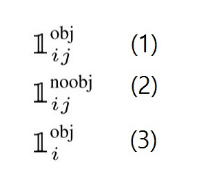

In [9]:
from IPython.display import Image
Image('../image/yolo_8.png', width=180)

(1): Object가 존재하는 grid cell i의 predictor bounding box j.


(2): Object가 존재하지 않는 gird cell i의 bounding box j


(3): Object가 존재하는 grid cell i
  
**\* Ground-truth box의 중심점이 어떤 grid cell 내부에 위치하면, 그 grid cell에는 Object가 존재한다고 여긴다.**

### Lost Function

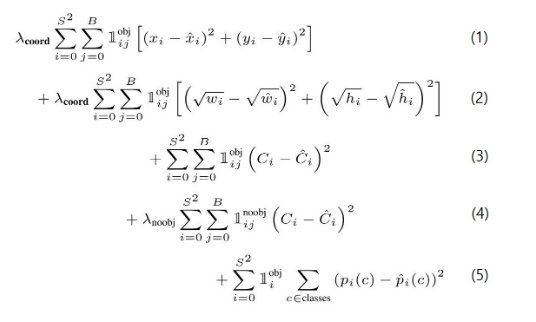

In [11]:
from IPython.display import Image
Image('../image/yolo_loss.png')

(1): **Object가 존재하는** grid cell i의 predictor bounding box j에 대해, x와 y의 loss를 계산.


(2): **Object가 존재하는** grid cell i의 predictor bounding box j에 대해, w와 h의 loss를 계산. 큰 box에 대해서는 small derivation을 반영하기 위해 제곱근을 취한 후, sum-squared error를 한다. ( 같은 error라도 larger box의 경우 상대적으로 IOU에 영향을 적게 준다.)


(3): **Object가 존재하는** gird cell i의 predictor bounding box j에 대해, confidence score의 loss를 계산.($C_i=1$)


(4): **Object가 존재하지 않는** grid cell i의 bounding box j에 대해, confidence score의 loss를 계산.($C_i=0$)


(5): **Object가 존재하는** grid cell i에 대해, conditional class probability의 loss계산. (Correct class c: $p_i(c)=1, \ otherwise:p_i(c)=0$)


$\lambda_{coord}$: coordinates(x, y, w, h)에 대한 loss와 다른 loss들과의 균형을 위한 balancing parameter.


$\lambda_{noobj}$: obj가 있는 box와 없는 box간의 균형을 위한 balancing parameter.(일반적으로 image내에는 obj가 있는 cell보다는 obj가 없는 cell이 훨씬 많으므로)

## YOLO의 한계
1. 각각의 grid cell이 하나의 클래스만을 예측할 수 있으므로, 작은 object가 어려개 다다닥 붙어있으면 예측이 제대로 이루어지지 못한다.


2. bounding box의 형태가 training data를 통해서만 학습되므로, 새로운/독특한 형태의 bounding box의 경우 정확히 예측하지 못한다.


3. 몇 단계의 layer를 거쳐서 나온 feature map을 대상으로 bounding box를 예측하므로 localization이 다소 부정확해지는 경우가 있다.